# RED

Para Crear la red se utilizaron la lista de adyacencia de palabras, se utiliza una lista de adyacencia pues consume menos espacio que una matriz de adyacencia.

In [1]:
# Import Packages
import networkx as nx
import pandas as pd
import numpy as np
import random

In [2]:
#Import Data-Frame
Df=pd.read_csv("CN_spa.csv",header=None)
Df.head()

,0,1
0,abeja,abejorro
1,aguila,aguilucho
2,abeja,arana
3,arenque,atun
4,abeja,avispa


Para generar la red compleja semantica se selecciona una columna de fuente $0$, y una columna objetivo $1$, esto permite que los elaces se creen de acuerdo a las parejas de la lista de adyacencia.

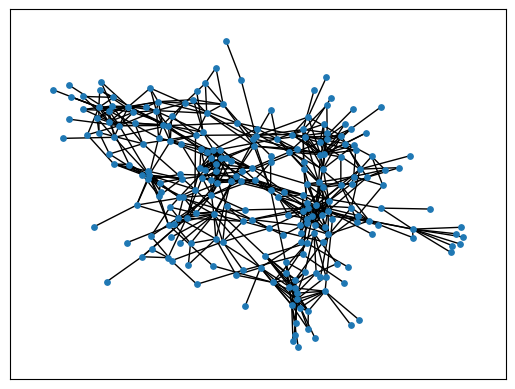

In [3]:
#Semantic Network
G=nx.from_pandas_edgelist(Df,source=0,target=1)# crea la red desde el Df
Graph=nx.draw_networkx(G, with_labels=False, node_size=15)#Dibuja la red de acuerdo a los parametros de G; sin etiquetas y con tamaño de nodo 15

### Caracterisitcas de la Red

In [4]:
print("numero de nodos:", G.number_of_nodes())
print("numero de enlaces:", G.number_of_edges())

#Distribucion de grado
degree=nx.degree(G)
degree=pd.DataFrame(degree)
meandegree=np.mean(degree.iloc[:,1])
print("grado medio de la red:", meandegree)

#coef clustering
coef_clustering=nx.average_clustering(G)
print("coeficiente de clustering:", coef_clustering)

#camino mas corto
short_path=nx.average_shortest_path_length(G)
print("longitud del camino mas corto:", short_path)


numero de nodos: 236
numero de enlaces: 611
grado medio de la red: 5.177966101694915
coeficiente de clustering: 0.3296154175391464
longitud del camino mas corto: 4.4232960692390915


# Modelos de busqueda

En las siguientes secciones se presetnan los codigos para desarrollar los modelos de busqueda.

Se realizaran 7 modelos de busqueda, comenzando por un modelo global llamado *busqueda por grado de nodo* o **NDS** por sus siglas en ingles. Los modelos de caminata aleatoria censurada, basados en los sesgos presetnados por Goñi et. al. Un modelo de busqueda similar al usado en arboles de decision llamado *busqueda profunda primero basada en cluster*, la cual es un modelo local de busqueda. Un modelo de camianta aleatoria con vectores de cebado y por ultimo un modelo de activacion de propagación.

## NDS: busqueda por grado de nodo

Este modelo selecciona nodos aleatorios con probabilidad de acuerdo a su grado, asi un nodo con mayor grado tiene mayor probabilidad de ser elegido, este modelo no sencura, por lo que la lista generada contiene elementos repetidos.

In [5]:
#definir la probabilidad de cada nodo
def prob_elec_nodo(grafo, num_nodo):
    probabilidad={}
    grado_total=sum(dict(grafo.degree()).values())

    for nodo, grado in grafo.degree():
        probabilidad[nodo]=grado/grado_total

    nodo_elegido=[]
    while len(nodo_elegido)< num_nodo:
        rand_value=random.random()
        prob_acumulada=0

        for node, prob in probabilidad.items():
            prob_acumulada+= prob
            if rand_value <= prob_acumulada:
                nodo_elegido.append(node)
                break
    return nodo_elegido


In [6]:
numerosdenodos=236
elegidos=prob_elec_nodo(G,numerosdenodos)
elegidos=pd.DataFrame(elegidos)

In [7]:
elegidos.head()

,0
0,koala
1,trucha
2,pantera
3,cucaracha
4,pollo


#### Duda
La duda en este modelo es que me genera una lista, los modelos sigueitne logro hacer que genere una matriz de adyacencia y posteriormente una red, sin embargo como este codigo genera una lista no se como lograr generar una red.

## CFDS: busqueda primero basada en cluster

## CRW Caminata aleatoria censurada

Para hacer la caminata aleatoria censurada se usa las cadenas de markov presentadas por Goñi et. al. para esto se crea una funcion de cambio determinada como:
$$
P^{srw}_{ij}=qP^{sw}_{ij}+(1-q)P^{cl}_{ij}
$$

In [8]:
#definir la funcion de switching
def SRW(p,mc,ms):
    #p=probabilidad de cambiar de zona
    #1-p probabilidad de no cambiar de zona
    return p*ms+(1-p)*mc

In [9]:
""" Hallar la matriz estacionaria"""

# primero encontrar la matriz de adyacencia de la red G
adjacenci=nx.adjacency_matrix(G).todense()
adjacenci=pd.DataFrame(adjacenci)
adjacenci.head()# luego hallar la matriz de estacionaria de acuerdo a la ecuacion anterior
Smatrix=adjacenci/adjacenci.sum(axis=1)
Smatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
0,0.000,0.333333,0.000000,0.0,0.1,0.0,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.125,0.000000,0.000000,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,0.000000,0.071429,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.125,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para generar la matriz de cambio se tiene en cuenta el siguiente sesgo
$$
\lambda_j = \frac{1}{|V|}
$$

Esto es que todos los nodos tiene igual probabilidad de ser elegidos en la caminata.

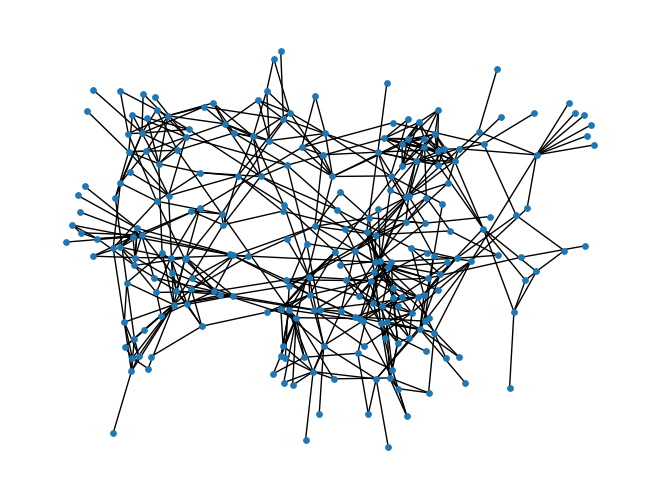

In [49]:
#Crear la matriz de cambio
mccrw=pd.read_csv("crw.csv",header=None)
#probabilidad
p=0.2
#aplica el modelo
crw=SRW(p,mccrw,Smatrix)

crw.to_numpy()
adyacenci_crw=np.where(crw>= 0.1,1,0)
gcrw=nx.from_numpy_array(adyacenci_crw)
nx.draw(gcrw,node_size=15)

In [50]:
print("numero de nodos:", gcrw.number_of_nodes())
print("numero de enlaces:", gcrw.number_of_edges())

#Distribucion de grado
degree_crw=nx.degree(gcrw)
degree_crw=pd.DataFrame(degree_crw)
meandegree_crw=np.mean(degree_crw.iloc[:,1])
print("grado medio de la red:", meandegree_crw)

#coef clustering
coef_clustering_crw=nx.average_clustering(gcrw)
print("coeficiente de clustering:", coef_clustering_crw)

#camino mas corto
short_path_crw=nx.average_shortest_path_length(gcrw)
print("longitud del camino mas corto:", short_path_crw)

numero de nodos: 236
numero de enlaces: 563
grado medio de la red: 4.771186440677966
coeficiente de clustering: 0.26429841345095567
longitud del camino mas corto: 4.548214929679048


## Switching Random Walk / CRW+RJ: Caminata aleatoria censurada con salto aleatorio.


En el caso de una caminata aleatoria censurada con saltos aleatorios se presenta el sesgo de tipo:
$$
\lambda_j = \frac{k(v_{j})}{\sum_{i\leq |V|}k(v_{i})}
$$

El sesgo hace que sea mas probable saltar a nodos con mayor numero de enlaces, permiteindo una busqueda global.

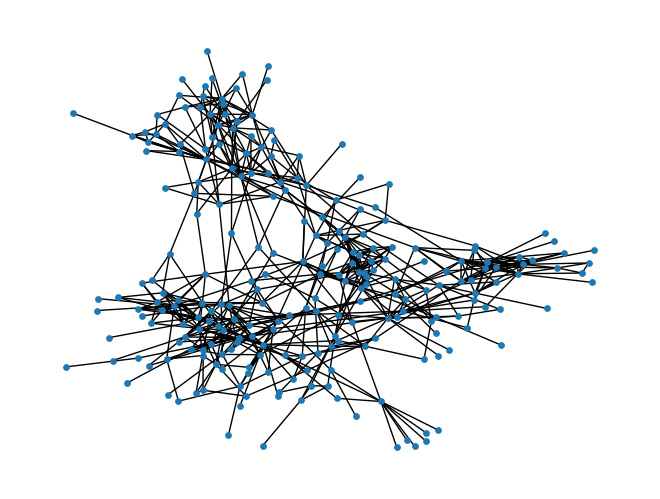

In [55]:
# Crear una matriz de probabildiad de cambio
mccrwrj=pd.read_csv("srwmas.csv",header=None,delimiter=",")
#definir la probabilidad p
p=0.2

#aplciar el modelo anterior
crwrj=SRW(p,mccrwrj,Smatrix)

#crear una matrix de adyacencia de los nuevos datos
crwrj.to_numpy()
adyacenci_crwrj=np.where(crwrj>= 0.01,1,0)
gcrwrj=nx.from_numpy_array(adyacenci_crwrj)
nx.draw(gcrwrj,node_size=15)

In [56]:
print("numero de nodos:", gcrwrj.number_of_nodes())
print("numero de enlaces:", gcrwrj.number_of_edges())

#Distribucion de grado
degree_crwrj=nx.degree(gcrwrj)
degree_crwrj=pd.DataFrame(degree_crwrj)
meandegree_crwrj=np.mean(degree_crwrj.iloc[:,1])
print("grado medio de la red:", meandegree_crwrj)

#coef clustering
coef_clustering_crwrj=nx.average_clustering(gcrwrj)
print("coeficiente de clustering:", coef_clustering_crwrj)

#camino mas corto
short_path_crwrj=nx.average_shortest_path_length(gcrwrj)
print("longitud del camino mas corto:", short_path_crwrj)

numero de nodos: 236
numero de enlaces: 611
grado medio de la red: 5.177966101694915
coeficiente de clustering: 0.3296154175391464
longitud del camino mas corto: 4.4232960692390915


## CRW+SJ: Caminata aleatoria censurada con salto estrategico

El sesgo que permite modelar la caminta aleatoria con salto estrategico es el que se presetna como una caminata aleatoria con gradiente negativo.
$$
\lambda_j = \frac{K-k(v_{j})+1}{\sum_{i\leq |V|}k(v_{i})}
$$

Por lo que existe una probabilidad mayor de elegir nodos con pocos enlaces, formando una busqueda local.

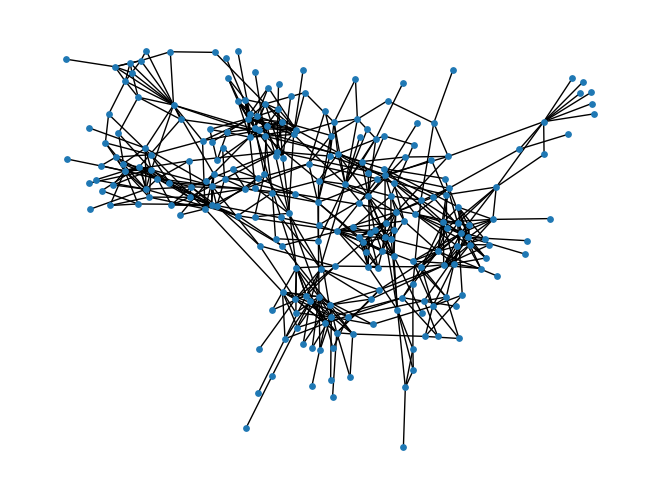

In [59]:
#Definir la probabilidad
p=0.2

#matriz de cambios
mccrwsj=pd.read_csv("crwmenos.csv",header=None)

#aplicar la funcion de random walk
crwsj=SRW(p,mccrwsj,Smatrix)

#crear una matrix de adyacencia de los nuevos datos
crwsj.to_numpy()
adyacenci_crwsj=np.where(crwsj>= 0.01,1,0)
gcrwsj=nx.from_numpy_array(adyacenci_crwsj)
nx.draw(gcrwsj,node_size=15)


In [60]:
print("numero de nodos:", gcrwsj.number_of_nodes())
print("numero de enlaces:", gcrwsj.number_of_edges())

#Distribucion de grado
degree_crwsj=nx.degree(gcrwsj)
degree_crwsj=pd.DataFrame(degree_crwsj)
meandegree_crwsj=np.mean(degree_crwsj.iloc[:,1])
print("grado medio de la red:", meandegree_crwsj)

#coef clustering
coef_clustering_crwsj=nx.average_clustering(gcrwsj)
print("coeficiente de clustering:", coef_clustering_crwsj)

#camino mas corto
short_path_crwsj=nx.average_shortest_path_length(gcrwsj)
print("longitud del camino mas corto:", short_path_crwsj)

numero de nodos: 236
numero de enlaces: 611
grado medio de la red: 5.177966101694915
coeficiente de clustering: 0.3296154175391464
longitud del camino mas corto: 4.4232960692390915


## CRW+pv: caminata aleatoria censurada con vector de cebado.

## SA: modelo de activador de dispersion.